# setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Build the model

![model_structure.jpg](./model_structure.jpg)

In [2]:
class Lstm_classifier(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, embed_dim, num_layers, batch_first, bidirectional):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        super().__init__()
        
        self.embed = nn.Embedding(self.input_size, self.embed_dim)
        
        self.lstm = nn.LSTM(
            input_size = self.embed_dim,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.linear = nn.Sequential(
            nn.ReLU(),   # activation
            nn.BatchNorm1d(self.hidden_size*2),   # normalize before linear layer
            nn.Linear(self.hidden_size*2, self.output_size),    # dim reduction
            nn.Sigmoid(),    # get the probability value
        )
    
    def forward(self, x):
        # |x| = (bs, t, input_size)
        x = self.embed(x)
        # |x| = (bs, t, embed_dim)
        z, _ = self.lstm(x)  # output of nn.LSTM = output(for all t-step), (hidden_state, cell_state) 
        # |z| = (bs, t, hidden_size * # directions)
        z = z[:, -1, :].squeeze(1) # pick the last time-step output + squeeze   
        # |z| = (bs, hidden_size * #direction) = 2 dim
        y_pred = self.linear(z)
        # |y_pred| = (bs, 1)
        
        return y_pred

In [3]:
# |v| = |input| = 20,000
# hidden_size = 128
# n_layers = 3

model = Lstm_classifier(input_size=20002, 
                        hidden_size=128, 
                        output_size=1, 
                        embed_dim=128,
                        num_layers=3, 
                        batch_first=True, 
                        bidirectional=True)
model

Lstm_classifier(
  (embed): Embedding(20002, 128)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True, bidirectional=True)
  (linear): Sequential(
    (0): ReLU()
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

# Load the IMDB movie review sentiment data

[keras]
- tokenization + vocabulary 생성 (max_features = 20,000 = |vocab|, 단어를 정수로 인코딩)
    - 여기까지 keras는 이미 되어있는 상태
- pad_sequences

[torch]
- load
- tokienization
    - data.Field
        - max_length = 200
    - TabularDataset
        - **tokenized train / test dataset 생성**
- vocabulary 생성 (정수 encoding)
    - TEXT.build_vocab(train_data, max_size=20000)
        - pad token 생성
        - **tokenized + padding + train/test set 생성**
- dataloader 생성
    - BucketIterator()
        - **train / val / test loader 생성**



- 참고 : https://pytorch.org/text/0.8.1/datasets.html#imdb
- 참고 : https://wikidocs.net/60314




[torchtext]
- Field 정의(text, label 데이터)
- TabularDataset 정의 : Field에서 정의한 대로 tokenization 수행 + 기본적인 전처리 후 데이터셋 구성 (train / test data)
- Vocabulary 생성 (token별 정수 encoding)
- DataLoader 생성 (BucketIterator)

## load data


In [4]:
import urllib.request
import pandas as pd

In [5]:
# get the file 'csv' form

# urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")


In [6]:
df = pd.read_csv('IMDb_Reviews.csv')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [7]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 50000


In [8]:
train_df = df[:25000]
test_df = df[25000:]

In [9]:
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

## field 정의하기

- torchtext.data
- tokenizer 정의



- Field : 전처리를 진행할 대상의 객체를 정의. text데이터를 위한 TEXT 객체, label데이터를 위한 LABEL 객체.
    - 향후 TabularDataset에서 TEXT, LABEL Field에 맞게 text데이터, label데이터가 각각 전처리 됨.

In [10]:
from torchtext.data import Field, BucketIterator

In [11]:
TEXT = Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  lower=True,
                  batch_first=True,
                  fix_length=200)

LABEL = Field(sequential=False,
               use_vocab=False,
               batch_first=False,
               is_target=True)

/home/jeongseobkim/anaconda3/envs/reboost/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## 데이터셋 만들기

- train/test set split
    - each text / label

In [12]:
from torchtext.data import TabularDataset

In [13]:
train_data, test_data = TabularDataset.splits(
        path='.', train='train_data.csv', test='test_data.csv', format='csv',
        fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

/home/jeongseobkim/anaconda3/envs/reboost/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/jeongseobkim/anaconda3/envs/reboost/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [14]:
print('훈련 샘플의 개수 : {}'.format(len(train_data)))
print('테스트 샘플의 개수 : {}'.format(len(test_data)))

훈련 샘플의 개수 : 25000
테스트 샘플의 개수 : 25000


In [15]:
print(train_data[0])
print('----')
print(vars(train_data[0]))
print('----')
print(train_data[0].text)
print('----')
print(train_data[0].label)

----
{'text': ['my', 'family', 'and', 'i', 'normally', 'do', 'not', 'watch', 'local', 'movies', 'for', 'the', 'simple', 'reason', 'that', 'they', 'are', 'poorly', 'made,', 'they', 'lack', 'the', 'depth,', 'and', 'just', 'not', 'worth', 'our', 'time.<br', '/><br', '/>the', 'trailer', 'of', '"nasaan', 'ka', 'man"', 'caught', 'my', 'attention,', 'my', 'daughter', 'in', "law's", 'and', "daughter's", 'so', 'we', 'took', 'time', 'out', 'to', 'watch', 'it', 'this', 'afternoon.', 'the', 'movie', 'exceeded', 'our', 'expectations.', 'the', 'cinematography', 'was', 'very', 'good,', 'the', 'story', 'beautiful', 'and', 'the', 'acting', 'awesome.', 'jericho', 'rosales', 'was', 'really', 'very', 'good,', "so's", 'claudine', 'barretto.', 'the', 'fact', 'that', 'i', 'despised', 'diether', 'ocampo', 'proves', 'he', 'was', 'effective', 'at', 'his', 'role.', 'i', 'have', 'never', 'been', 'this', 'touched,', 'moved', 'and', 'affected', 'by', 'a', 'local', 'movie', 'before.', 'imagine', 'a', 'cynic', 'like'

In [16]:
print(train_data.fields.items())

dict_items([('text', <torchtext.data.field.Field object at 0x7f9d7cc1d580>), ('label', <torchtext.data.field.Field object at 0x7f9d7d060670>)])


## vocab 만들기

- tokenization 진행했으니, 이젠 정수 encoding 필요!(각 token을 integer encoding 실시)

In [17]:
TEXT.build_vocab(train_data, max_size=20000)

In [18]:
print(len(TEXT.vocab))

20002


20,000 + special token 2개(UNK : 0, PAD : 1)

In [19]:
print(TEXT.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f9d7cc1d340>>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'i': 9, 'this': 10, 'it': 11, 'that': 12, '/><br': 13, 'was': 14, 'as': 15, 'with': 16, 'for': 17, 'but': 18, 'on': 19, 'movie': 20, 'his': 21, 'not': 22, 'are': 23, 'you': 24, 'film': 25, 'have': 26, 'he': 27, 'be': 28, 'at': 29, 'one': 30, 'by': 31, 'an': 32, 'they': 33, 'from': 34, 'who': 35, 'all': 36, 'like': 37, 'so': 38, 'just': 39, 'or': 40, 'has': 41, 'about': 42, "it's": 43, 'if': 44, 'her': 45, 'some': 46, 'out': 47, 'what': 48, 'very': 49, 'when': 50, 'more': 51, 'there': 52, 'even': 53, 'would': 54, 'my': 55, 'good': 56, 'she': 57, 'their': 58, 'only': 59, 'no': 60, 'really': 61, 'can': 62, 'up': 63, 'had': 64, 'which': 65, 'see': 66, 'were': 67, 'than': 68, '-': 69, 'we': 70, 'been': 71, 'into': 72, 'get': 73, 'much': 74, 'will': 75, 'because': 76, 'story': 77, 'most': 78, 'how': 7

## dataloader

In [20]:
train_data, valid_data = train_data.split(split_ratio = 0.7)

In [21]:
batch_size = 32

In [22]:
train_iter, val_iter, test_iter = BucketIterator.splits((train_data, valid_data, test_data),
                                                        sort_key= lambda x: len(x.text), 
                                                        sort_within_batch=False,
                                                        batch_size=batch_size)

# train_iter, val_iter, test_iter = BucketIterator.splits((train_data, valid_data, test_data),
#                                                         sort=False,
#                                                         batch_size=batch_size)

/home/jeongseobkim/anaconda3/envs/reboost/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


**debugging**
- (1차)
    - val_iter의 validation 과정에서 typeerror
        - error 문
            ```
            TypeError: '<' not supported between instances of 'Example' and 'Example'
            ```
    - debugging 참고
        - https://github.com/pytorch/text/issues/474
        - https://discuss.pytorch.org/t/bert-with-torchtext-typeerror-not-supported-between-instances-of-example-and-example/101119
        
- (2차)
    - 1차에도 그대로
    - 이번엔 아예, sort=False 로..
        - 참고 : https://github.com/pytorch/text/issues/474

In [23]:
print('훈련 데이터의 미니 배치의 개수 : {}'.format(len(train_iter)))
print('검증 데이터의 미니 배치의 개수 : {}'.format(len(val_iter)))
print('테스트 데이터의 미니 배치의 개수 : {}'.format(len(test_iter)))

훈련 데이터의 미니 배치의 개수 : 547
검증 데이터의 미니 배치의 개수 : 235
테스트 데이터의 미니 배치의 개수 : 782


In [24]:
print(469*32, 313*32, 782*32)

15008 10016 25024


In [25]:
batch = next(iter(train_iter))
batch.text.shape

/home/jeongseobkim/anaconda3/envs/reboost/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


torch.Size([32, 200])

In [26]:
for a in train_iter:
    print(a.text)
    print(a.label)
    break

tensor([[    2,  1109,   169,  ...,     7,    22,     2],
        [   43,   564,    48,  ...,     1,     1,     1],
        [   82,     5,    36,  ...,     4,   109, 13240],
        ...,
        [    9,   144,   115,  ...,     1,     1,     1],
        [   10,    25,   275,  ...,     1,     1,     1],
        [    4,     0,  2995,  ...,     1,     1,     1]])
tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0])


In [27]:
batch = next(iter(train_iter))
print(batch.text.shape)
print(batch.label.shape)

torch.Size([32, 200])
torch.Size([32])


In [28]:
batch = next(iter(train_iter))
print(batch.text)
print('----')
print(batch.label)

tensor([[  258,    35,    41,  ...,    35,    41, 12187],
        [   79,   329,     6,  ...,     1,     1,     1],
        [  315,     0,  4550,  ...,   186,   124,   120],
        ...,
        [    0,     0,    13,  ...,     0,    58,   578],
        [ 1316,     0,     4,  ...,     1,     1,     1],
        [ 1506,    35,   438,  ...,   365,    45,  1440]])
----
tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0])


In [29]:
train_iter, val_iter, test_iter = BucketIterator.splits((train_data, valid_data, test_data),
                                                        sort_key= lambda x: len(x.text), 
                                                        sort_within_batch=False,
                                                        batch_size=batch_size,
                                                        shuffle=True)

# train_iter, val_iter, test_iter = BucketIterator.splits((train_data, valid_data, test_data),
#                                                         sort=False,
#                                                         batch_size=batch_size,
#                                                         shuffle=True)

|x| = (bs, 200)

# Train and evaluate the model

In [30]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [31]:
model.to(device)

Lstm_classifier(
  (embed): Embedding(20002, 128)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True, bidirectional=True)
  (linear): Sequential(
    (0): ReLU()
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [32]:
import torch.optim as optim

crit = nn.BCELoss()
optim = optim.Adam(model.parameters())

In [33]:
import numpy as np

lowest_loss = np.inf
best_model = None

n_epochs = 15
train_loss_list, val_loss_list = [], []
val_acc_list = []
lowest_loss_list = []

for epoch in range(1, n_epochs+1):
    
    train_loss, valid_loss = 0, 0
    correct_cnt = 0
    y_len = 0

    model.train()
    for batch in train_iter:
        x, y = batch.text.to(device), batch.label.to(device).float()
        y_hat = model(x).to(device) 

        loss = crit(y_hat.squeeze(), y)
        
        optim.zero_grad()

        loss.backward()

        optim.step()

        train_loss += float(loss)
        
    train_loss /= len(train_iter)
    train_loss_list.append(train_loss)
    
    model.eval()
    with torch.no_grad():
        for batch in val_iter:
            x, y = batch.text.to(device), batch.label.to(device).float()
            y_hat = model(x).to(device)
            y_len += len(y)

            loss = crit(y_hat.squeeze(), y)
            
            correct_cnt += (y == torch.round(y_hat).squeeze()).sum()
            
            valid_loss += float(loss)

        valid_loss /= y_len
        accuracy = correct_cnt / y_len
        
        val_loss_list.append(valid_loss)
        val_acc_list.append(accuracy)
        
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            best_model = model.state_dict()
            
        lowest_loss_list.append(lowest_loss)
        
    print("epoch : %d, val_acc : %.4f, train_loss : %.4f, val_loss : %.4f, lowest_loss : %.4f" % (epoch, 
                                                                                                  accuracy, 
                                                                                                  train_loss, 
                                                                                                  valid_loss, 
                                                                                                  lowest_loss))

epoch : 1, val_acc : 0.5017, train_loss : 0.6999, val_loss : 0.0226, lowest_loss : 0.0226
epoch : 2, val_acc : 0.5380, train_loss : 0.6864, val_loss : 0.0214, lowest_loss : 0.0214
epoch : 3, val_acc : 0.7005, train_loss : 0.5952, val_loss : 0.0198, lowest_loss : 0.0198
epoch : 4, val_acc : 0.8268, train_loss : 0.3395, val_loss : 0.0119, lowest_loss : 0.0119
epoch : 5, val_acc : 0.8315, train_loss : 0.1960, val_loss : 0.0127, lowest_loss : 0.0119
epoch : 6, val_acc : 0.8236, train_loss : 0.0953, val_loss : 0.0173, lowest_loss : 0.0119
epoch : 7, val_acc : 0.8192, train_loss : 0.0442, val_loss : 0.0285, lowest_loss : 0.0119
epoch : 8, val_acc : 0.8283, train_loss : 0.0308, val_loss : 0.0260, lowest_loss : 0.0119
epoch : 9, val_acc : 0.8297, train_loss : 0.0244, val_loss : 0.0277, lowest_loss : 0.0119
epoch : 10, val_acc : 0.8347, train_loss : 0.0212, val_loss : 0.0261, lowest_loss : 0.0119
epoch : 11, val_acc : 0.8272, train_loss : 0.0159, val_loss : 0.0334, lowest_loss : 0.0119
epoch : 

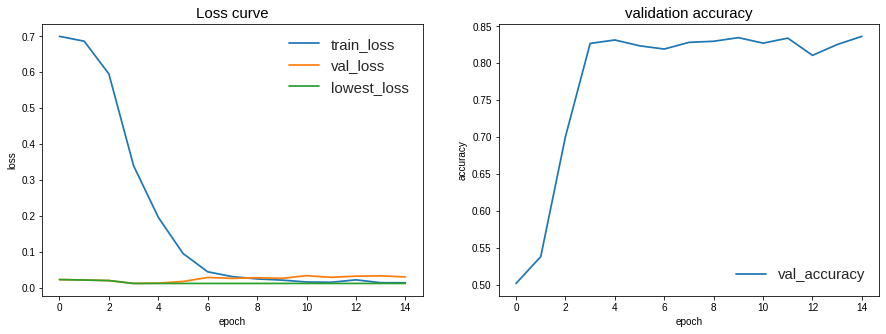

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1,2,figsize=(15,5))

plt.style.use("seaborn")

axes[0].plot(train_loss_list, label="train_loss")
axes[0].plot(val_loss_list, label="val_loss")
axes[0].plot(lowest_loss_list, label="lowest_loss")
axes[0].set_title("Loss curve", fontsize=15)
axes[0].legend(fontsize=15)
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")

axes[1].plot(val_acc_list, label="val_accuracy")
axes[1].set_title("validation accuracy", fontsize=15)
axes[1].legend(fontsize=15)
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")

plt.show()